In [1]:
#! pip install transformers==3.0.2
#https://github.com/DhavalTaunk08/NLP_scripts

In [2]:
# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

from transformers import BertTokenizer, BertModel, BertForMaskedLM
from scipy.spatial.distance import cosine
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import matplotlib

In [91]:


def get_bert_output(tokenizer_,model_,sentence):
  bert_text = "[CLS] " + sentence + " [SEP]"
  tokenized_text = tokenizer_.tokenize(bert_text)
  indexed_tokens = tokenizer_.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  with torch.no_grad():
    outputs = model_(tokens_tensor, segments_tensors)
  return outputs  

def get_bert_output_pooled(tokenizer_,model_,sentence):
  
  bert_text = "[CLS] " + sentence + " [SEP]"
  tokenized_text = tokenizer_.tokenize(bert_text)
  indexed_tokens = tokenizer_.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  
  outputs = model_(tokens_tensor, segments_tensors)
  output_pooled =  outputs[1] 
  #print("output_pooled",output_pooled.squeeze().shape)
  return output_pooled.squeeze()  



#hidden layers are 1 initial embedding + 12 bert tranformer = 13 layers
def get_bert_hidden_layers(tokenizer_,model_,sentence):
  outputs = get_bert_output(tokenizer_,model_,sentence)
  hidden_states = outputs[2]
  return hidden_states  


#all hidden transformer states
def get_bert_layers(sentence):  
  hidden_states = get_bert_hidden_layers(sentence)

  token_embeddings = torch.tensor( [h.numpy() for h in hidden_states[1:]])
  #print(token_embeddings.shape)
  token_embeddings = token_embeddings.squeeze()
  #print(token_embeddings.shape)
  token_embeddings = token_embeddings.permute(1,0,2)
  #print(token_embeddings.shape)
  return token_embeddings

def get_word_embeddings_concatted(sentence) :
  token_embeddings = get_bert_layers(sentence)  
  #print(token_embeddings.shape)
  token_vecs_cat = []# `token_embeddings` is a [22 x 12 x 768] tensor.# For each token in the sentence...
  for token in token_embeddings:
    # `token` is a [12 x 768] tensor# Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

  return token_vecs_cat  

#get individual word embedding of sentence, remember [CLS] and [SEP] will be added
#also if any word is out of vocublary it will be replaced by some tokens
#   
def get_word_embeddings_sum(sentence) :
  token_embeddings = get_bert_layers(sentence)  
  token_vecs_sum = []# `token_embeddings` is a [22 x 12 x 768] tensor.# For each token in the sentence...
  #`token` is a [12 x 768] tensor# Sum the vectors from the last four layers.
  for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec) 
  return token_vecs_sum   

#get embedding of all sentence 
#hidden states [13,1,token_count,768]
#return mean of 
#To get a single (i.e., pooled) vector, you can do pooling over the first dimension of the tensor. 
#Max-pooling of average-pooling might make much more sense in this case than summing all the token embeddings. 
#When summing the values, vectors of differently long sentences are in different ranges and are not really comparable.
#last_hidden_states = model(input_ids)
#features = last_hidden_states[0][:,0,:].numpy() # considering o only the [CLS] for each sentences 
#features.shape
#The sentence embedding will never contain all the information in the original sentence; 
#they contain the information that is most useful for the training task. If an embedding doesn't prove useful for your problem, you'll either have to continue training it for a few iterations, or find an embedding that is suited for your task.
#4.1. Special tokens

#It should be noted that although the [CLS] acts as an "aggregate representation" for classification tasks, this is not the best choice for a high quality sentence embedding vector. According to BERT author Jacob Devlin: "I'm not sure what these vectors are, since BERT does not generate meaningful sentence vectors. It seems that this is is doing average pooling over the word tokens to get a sentence vector, but we never suggested that this will generate meaningful sentence representations."

#(However, the [CLS] token does become meaningful if the model has been fine-tuned, where the last hidden layer of this token is used as the "sentence vector" for sequence classification.)
def get_sentence_embedding(tokenizer_,model_,sentence,layer_start=-4,layer_end=None,type="sumsum"):
  hidden_states = get_bert_hidden_layers(tokenizer_,model_,sentence)
  effective_layers = torch.stack(hidden_states[layer_start:layer_end])
  #effective_layers = torch.stack( [hidden_states[s] for s in layers] )
  #print("effective_layers",effective_layers.shape)
  if type == "sumsum":
    sentence_embedding = torch.sum(effective_layers.sum(0).squeeze(), dim=0) 
  elif type == "summean":  
    sentence_embedding = torch.sum(effective_layers.mean(0).squeeze(), dim=0) 
  elif type == "meanmean":  
    sentence_embedding = torch.mean(effective_layers.mean(0).squeeze(), dim=0)    
  else:
    sentence_embedding = torch.mean(effective_layers.sum(0).squeeze(), dim=0)      

  return sentence_embedding


class EmbeddingPair:
  def __init__(self,word,vector):
    self.word = word
    self.vector = vector

def get_embeddings_as_pair(sentence,embeddings):
  bert_text = "[CLS] " + sentence + " [SEP]"
  tokenized_text = tokenizer.tokenize(bert_text)
  #print( tokenized_text )
  #for index in range(len(tokenized_text)):
  #  print( tokenized_text[index],":",embeddings[index].shape)
  return [ EmbeddingPair(tokenized_text[index] , embeddings[index]) for index in range(len(tokenized_text)) ]

def get_word_embeddings(sentence,embeddings,word):
  embeddings_as_pairs = get_embeddings_as_pair(sentence,embeddings)
  word_embeddings = []
  for pair in embeddings_as_pairs:
    if pair.word == word:
      word_embeddings.append( pair )
  return word_embeddings  

def get_word_embeddings(sentence,word):
  embeddings = get_word_embeddings_sum( sentence )
  embeddings_as_pairs = get_embeddings_as_pair(sentence,embeddings)
  word_embeddings = []
  for pair in embeddings_as_pairs:
    if pair.word == word:
      word_embeddings.append( pair )
  return word_embeddings  

def get_similarity(vector1,vector2):
  return 1 - cosine(vector1, vector2)  
  
    
def get_pooler_outputfrom(text,tokenizer_,model_):
    #TODO no need for this operation
    text = " ".join(text.split())

    inputs = tokenizer_.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length= MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
    input_ids = torch.tensor(inputs["input_ids"], dtype=torch.long)
    attention_mask = torch.tensor(inputs["attention_mask"], dtype=torch.long)
    output_1 = model_(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
    return output_1["pooler_output"].squeeze()

def get_CLS_output(text,tokenizer_,model_):
    #TODO no need for this operation
    text = " ".join(text.split())

    inputs = tokenizer_.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length= MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
    input_ids = torch.tensor(inputs["input_ids"], dtype=torch.long)
    attention_mask = torch.tensor(inputs["attention_mask"], dtype=torch.long)
    output_1 = model_(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
    cls_output = output_1["last_hidden_state"].squeeze()[0]
    return cls_output



In [4]:
#TODO remove color parts
#def get_color(s): if s.find("eat")


def map_on_3d(data_2d,words,color_mapping:None,exceptional_words=[],use_word_colors=False,fig_size=[19,11]):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    ax = plt.axes(projection ="3d")
    #scatter result words
    ax.scatter3D(data_2d[:, 0], data_2d[:, 1], data_2d[:, 2])
            
    #put an annotation on x,y cordinates for words
    for i, word in enumerate(words):
        if color_mapping is not None:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color=color_mapping[i] )
        elif word in exceptional_words:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#0000ff' )
        elif use_word_colors:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color=get_color(word))
        elif "eat" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#0000ff')
        elif "drink" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#00ff00')
        elif "read" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#ff0000')     
        else:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#ff00dd')
    plt.show()

def get_color_mapping(Ys,color_by="verb"):
  
  mapped_colors = []
  if color_by == "verb":    
    colors =["#ff0000","#00dd00","#0000dd"] 
    verbs = ["eat","drink"," read"] #bread has "read" process carefully
    for y in Ys:
      indexes = [i for i,verb in enumerate(verbs) if y.find(verb) > -1]
      mapped_colors.append(colors[indexes[0]] )

  if color_by == "object":    
    colors =["#ff0000","#aaaa00","#00ff00","#000220","#0000ff","#00aaaa"] 
    objects = ["apple","bread","water","beer","book","newspaper"]
    for y in Ys:
      indexes = [i for i,object in enumerate(objects) if y.find(object) > -1]
      mapped_colors.append(colors[indexes[0]] )    
    
  return mapped_colors  

def map_on_2d(data_2d,words,color_mapping:None,exceptional_words=[],use_word_colors=False,fig_size=[19,11]):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    #scatter result words
    plt.scatter(data_2d[:, 0], data_2d[:, 1])        
    
    #put an annotation on x,y cordinates for words
    for i, word in enumerate(words):
        if color_mapping is not None:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color=color_mapping[i] )
        elif word in exceptional_words:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff' )
        elif use_word_colors:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color=get_color(word))
        elif "eat" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff')
        elif "drink" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#00ff00')
        elif "read" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff0000')     
        else:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff00dd')
    plt.show()   

def dump_on_surface(Xs,Ys,fitting="tsne",dump_3d=True,dump_2d=True,color_by="verb"):    
    color_mapping = get_color_mapping(Ys,color_by)
    #print(color_mapping)
                             
    if dump_3d:    
        X_transformed = None
        if fitting=="tsne":
          X_transformed = PCA(n_components=3).fit_transform(np.array(Xs))
        else:   
          X_transformed = TSNE(n_components=3).fit_transform(np.array(Xs))
        map_on_3d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[10,10])
    if dump_2d:    
        pca = PCA(n_components=2)
        X_transformed = pca.fit_transform(np.array(Xs))
        map_on_2d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[10,10])

In [5]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
eng_german_sentences = [['i want to eat bread', 'ich mochten brot essen'],
 ['i want to eat apple', 'ich mochten apfel essen'],
 ['i want to drink water', 'ich mochten wasser trinken'],
 ['i want to drink beer', 'ich mochten bier trinken'],
 ['i want to read book', 'ich mochten buch lesen'],
 ['i want to read newspaper', 'ich mochten zeitung lesen'],
 ['i can eat bread', 'ich konnen brot essen'],
 ['i can eat apple', 'ich konnen apfel essen'],
 ['i can drink water', 'ich konnen wasser trinken'],
 ['i can drink beer', 'ich konnen bier trinken'],
 ['i can read book', 'ich konnen buch lesen'],
 ['i can read newspaper', 'ich konnen zeitung lesen'],
 ['we want to eat bread', 'wir mochten brot essen'],
 ['we want to eat apple', 'wir mochten apfel essen'],
 ['we want to drink water', 'wir mochten wasser trinken'],
 ['we want to drink beer', 'wir mochten bier trinken'],
 ['we want to read book', 'wir mochten buch lesen'],
 ['we want to read newspaper', 'wir mochten zeitung lesen'],
 ['we can eat bread', 'wir konnen brot essen'],
 ['we can eat apple', 'wir konnen apfel essen'],
 ['we can drink water', 'wir konnen wasser trinken'],
 ['we can drink beer', 'wir konnen bier trinken'],
 ['we can read book', 'wir konnen buch lesen'],
 ['we can read newspaper', 'wir konnen zeitung lesen'],
 ['i eat bread', 'ich essen brot'],
 ['i eat apple', 'ich essen apfel'],
 ['i drink water', 'ich trinken wasser'],
 ['i drink beer', 'ich trinken bier'],
 ['i read book', 'ich lesen buch'],
 ['i read newspaper', 'ich lesen zeitung'],
 ['we eat bread', 'wir essen brot'],
 ['we eat apple', 'wir essen apfel'],
 ['we drink water', 'wir trinken wasser'],
 ['we drink beer', 'wir trinken bier'],
 ['we read book', 'wir lesen buch'],
 ['we read newspaper', 'wir lesen zeitung']]

In [7]:
sentences = [ s[0] for s in eng_german_sentences ]
sentences[0]

'i want to eat bread'

In [8]:
MAX_LEN = 8
#bert_model_nottrained,tokenizer_nottrained

In [95]:
bert_model_nottrained = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True )
bert_model_nottrained.eval()
tokenizer_nottrained = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)


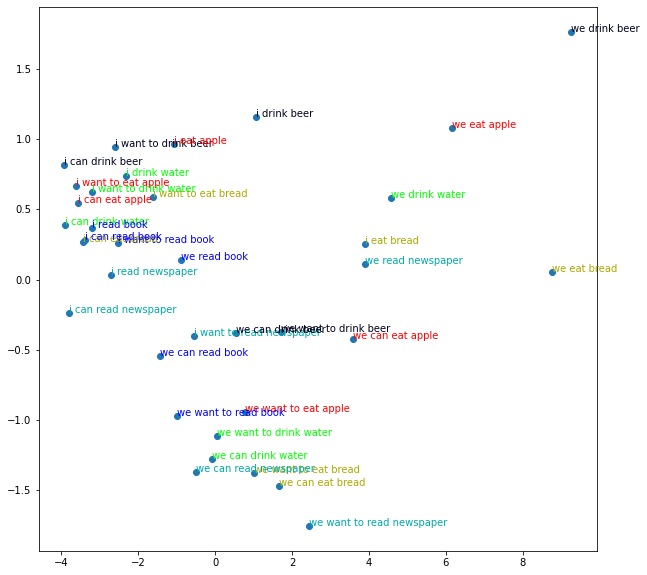

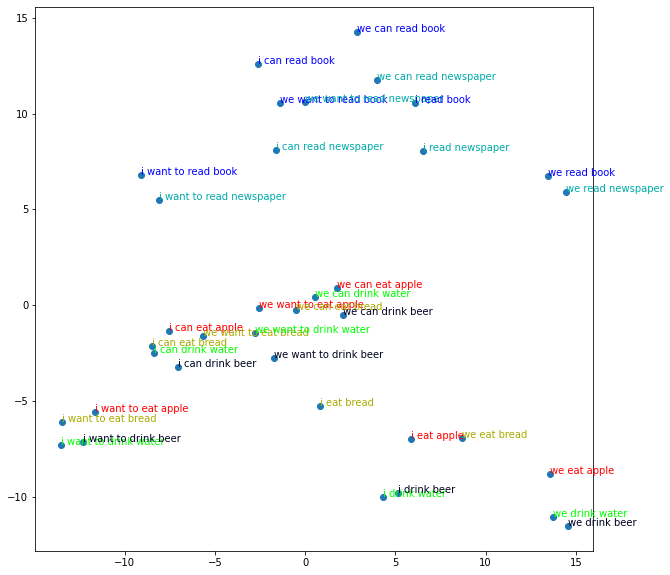

In [97]:

outputs = [ get_pooler_outputfrom(s,tokenizer_nottrained,bert_model_nottrained).detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object")

outputs = [ get_sentence_embedding(tokenizer_nottrained,bert_model_nottrained,s,type="meansum").detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object")

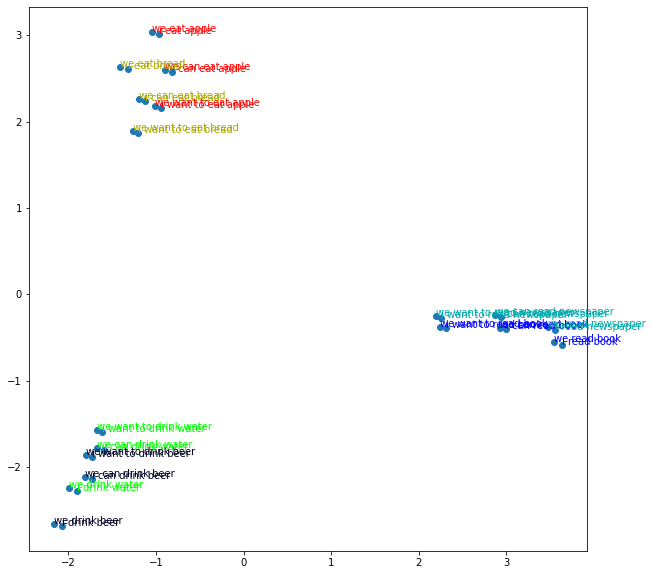

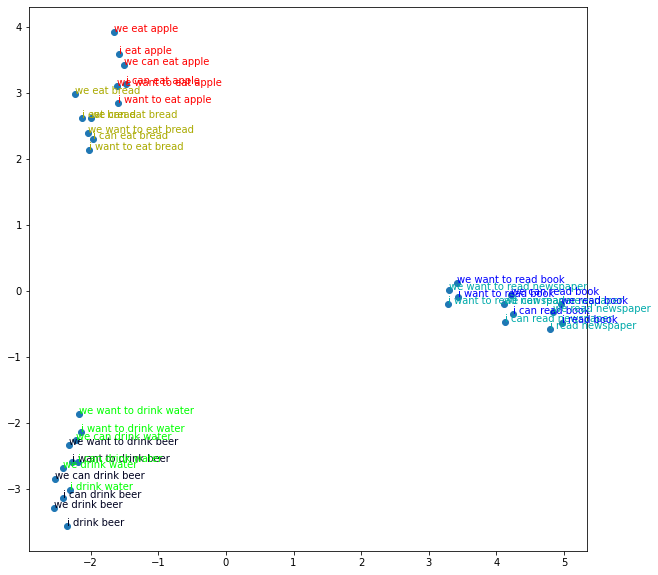

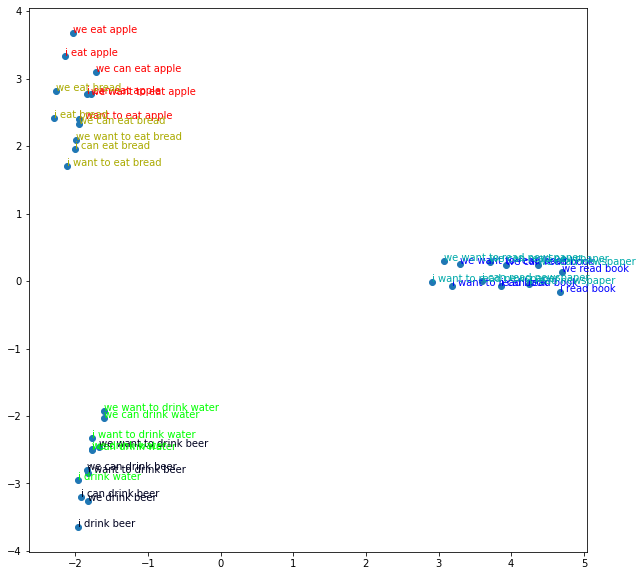

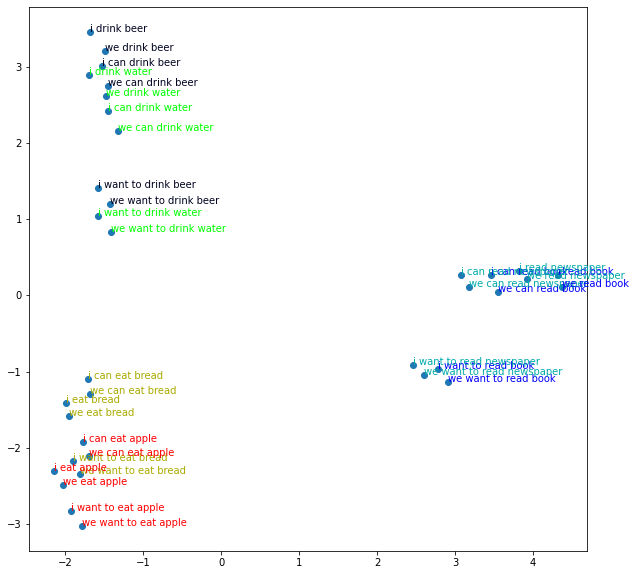

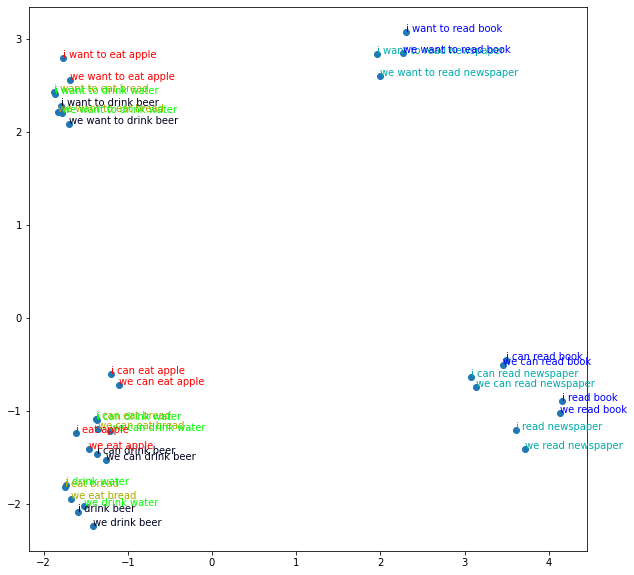

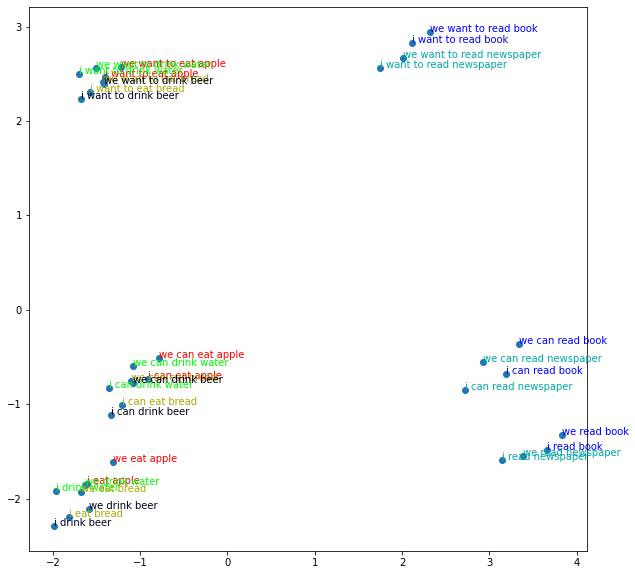

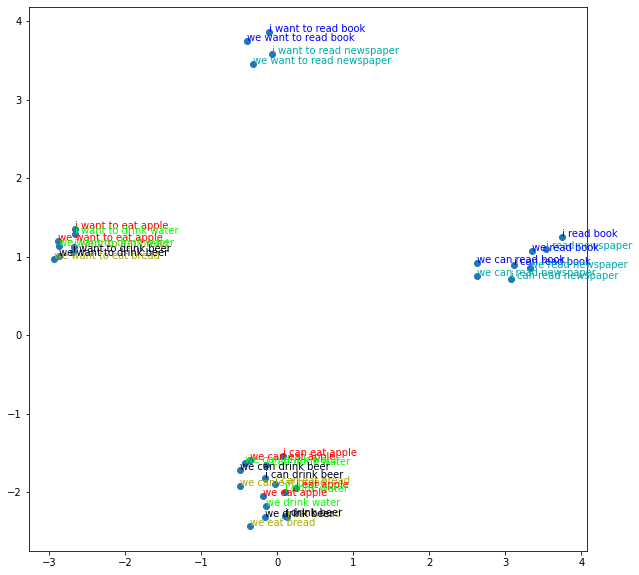

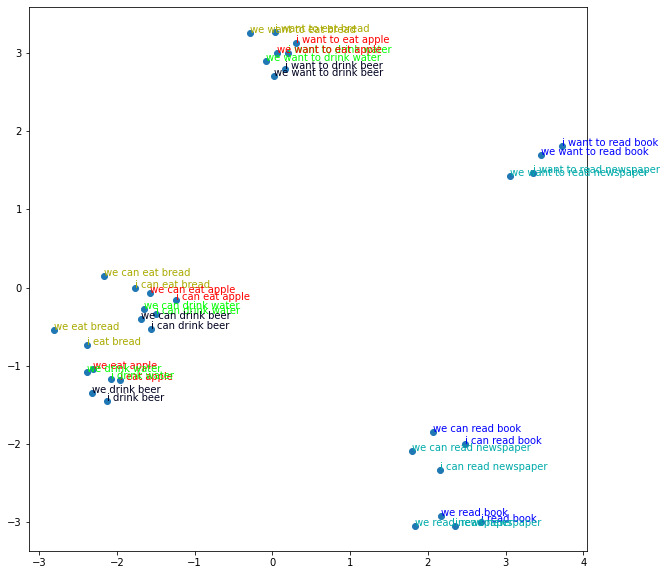

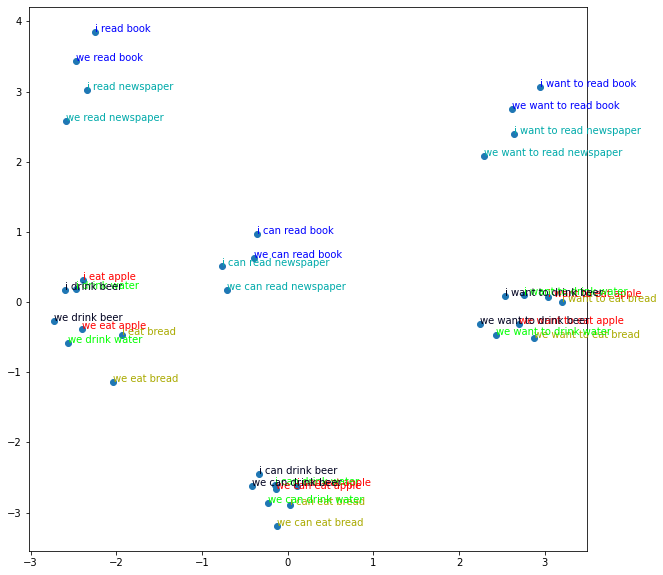

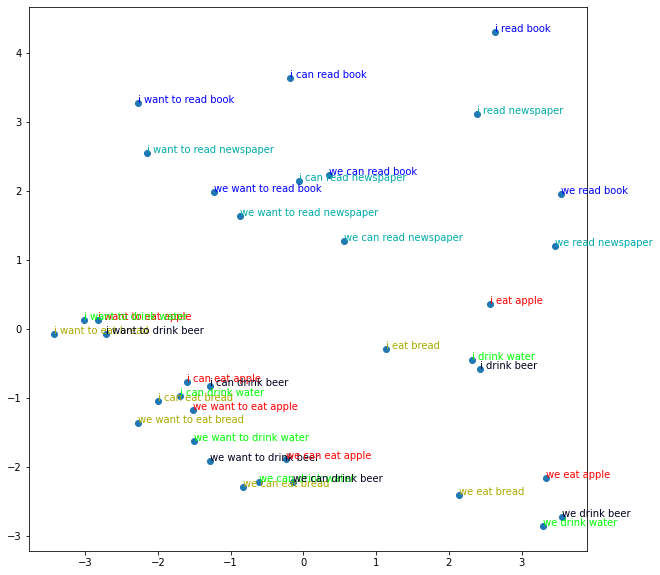

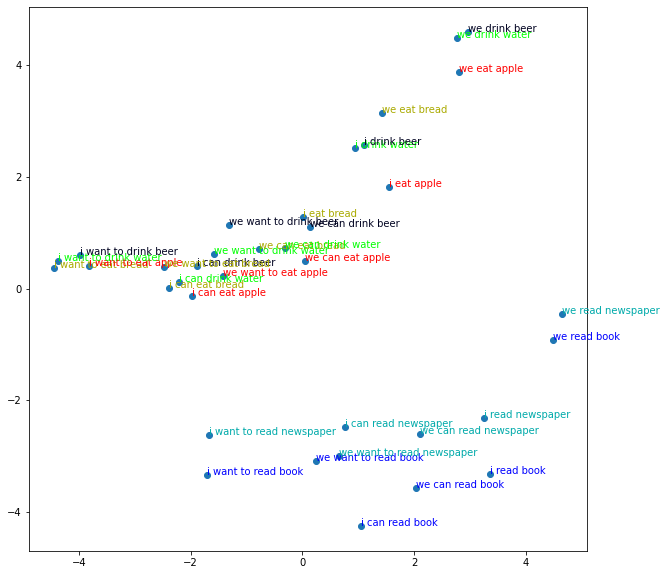

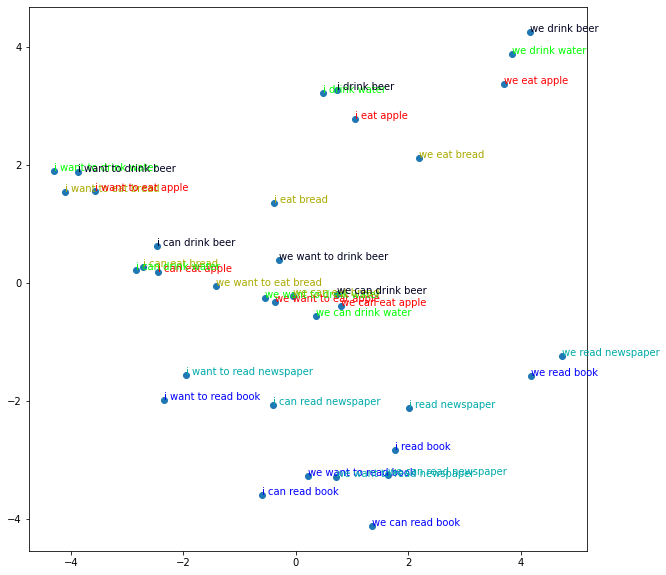

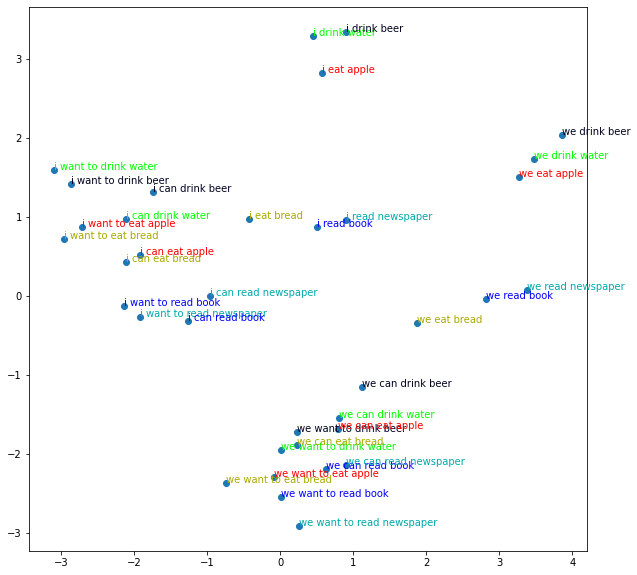

In [11]:
for i in range(13):
    
    pooler_outputs = [ get_sentence_embedding(tokenizer_nottrained,bert_model_nottrained,s,layer_start=i,layer_end=i+1,type="meanmean").detach().numpy() for s in sentences]
    #pooler_outputs = [ get_sentence_embedding(tokenizer_nottrained,bert_model_nottrained,s,layer_start=i,layer_end=i+1,type="meansum").detach().numpy() for s in sentences]
    #show_embeddings([],[],pooler_outputs,sentences,fitting="pca")
    dump_on_surface(pooler_outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object")

In [98]:
import pandas as pd

def get_group_by_object(s):
    objects = ["apple","bread","water","beer","book","newspaper"]
    for index,obj in enumerate(objects):
        if s.find(obj) > 0:
            return index

def get_group_by_verb(s):
  if s.find("drink") > 0:
    return 0
  elif s.find("eat") > 0:
    return 1
  else:
    return 2        
        
def get_df_by_object():
    df = pd.DataFrame()
    df["Sentence"] = sentences
    df["Group"] = [ get_group_by_object(s) for s in sentences]
    return df

def get_df_by_verb():
    df = pd.DataFrame()
    df["Sentence"] = sentences
    df["Group"] = [ get_group_by_verb(s) for s in sentences]
    return df

In [99]:
input_df = None
CLASS_NUMS = None

#input_df = get_df_by_object()
#CLASS_NUMS = 6

input_df = get_df_by_verb()
CLASS_NUMS = 3


input_df.head()

,Sentence,Group
0,i want to eat bread,1
1,i want to eat apple,1
2,i want to drink water,0
3,i want to drink beer,0
4,i want to read book,2


In [100]:
# Sections of config

# Defining some key variables that will be used later on in the training

TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4

LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)


In [101]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Sentence
        self.targets = self.data.Group
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        target = self.targets[index]

        return text,target

In [102]:
train_size = 1
train_data=input_df.sample(frac=train_size,random_state=200)
test_data= train_data # input_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(input_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (36, 2)
TRAIN Dataset: (36, 2)
TEST Dataset: (36, 2)


In [103]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(training_set, **test_params)

In [104]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 



class BertClassifier(torch.nn.Module):
    def __init__(self,nntokenizer,nnmodel):
        super(BertClassifier, self).__init__()
        nnmodel.train()
        self.nnmodel = nnmodel #DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.nntokenizer = nntokenizer
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, CLASS_NUMS)

    def forward(self, sentence_list):
        pooler = torch.stack([get_bert_output_pooled(self.nntokenizer,self.nnmodel,s) for s in sentence_list ])
        #print("pooler ",pooler.shape)
        
        #hidden_state = output_1[0]
        #pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [105]:
#https://pytorch.org/hub/huggingface_pytorch-transformers/

In [106]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [107]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        
        sent = data[0]
        targets = data[1].to(device, dtype = torch.long)
        #print("sent",sent)
        
        outputs = model(sent)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        #print("outputs.data",outputs.data)
        big_val, big_idx = torch.max(outputs.data, dim=1)
        #print("big_val, big_idx,targets",big_val, big_idx,targets)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        #if _%5000==0:
        #    loss_step = tr_loss/nb_tr_steps
        #    accu_step = (n_correct*100)/nb_tr_examples 
        #    #print(f"Training Loss per 5000 steps: {loss_step}")
        #    print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    #print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [108]:
#bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased",output_hidden_states = True)
bert_model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True )
model = BertClassifier(tokenizer,bert_model)
bert_model.train()
_ = model.to(device)
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

EPOCHS = 8
for epoch in range(EPOCHS):
    train(epoch)

9it [00:25,  2.86s/it]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 0: 33.333333333333336
Training Accuracy Epoch: 33.333333333333336


9it [00:27,  3.11s/it]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 50.0
Training Accuracy Epoch: 50.0


9it [00:27,  3.11s/it]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 61.111111111111114
Training Accuracy Epoch: 61.111111111111114


9it [00:27,  3.08s/it]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 80.55555555555556
Training Accuracy Epoch: 80.55555555555556


9it [00:30,  3.35s/it]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 4: 88.88888888888889
Training Accuracy Epoch: 88.88888888888889


9it [00:29,  3.30s/it]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 5: 97.22222222222223
Training Accuracy Epoch: 97.22222222222223


9it [00:31,  3.54s/it]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 6: 100.0
Training Accuracy Epoch: 100.0


9it [00:35,  3.96s/it]

The Total Accuracy for Epoch 7: 100.0
Training Accuracy Epoch: 100.0


In [110]:
_ = bert_model.eval()

In [111]:
text = "I eat apple"
text = " ".join(text.split())
#{
#            'ids': torch.tensor(ids, dtype=torch.long),
#            'mask': torch.tensor(mask, dtype=torch.long),
#            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
#            'targets': torch.tensor(self.targets[index], dtype=torch.float)
#        }

inputs = tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length= MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
input_ids = torch.tensor(inputs["input_ids"], dtype=torch.long)
attention_mask = torch.tensor(inputs["attention_mask"], dtype=torch.long)
token_type_ids = inputs["token_type_ids"]

print("input_ids",input_ids.shape)
print("attention_mask",attention_mask.shape)

print("input_ids",input_ids)
print("attention_mask",attention_mask)
print("token_type_ids",token_type_ids)

output_1 = bert_model(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
output_1.keys()
print("last_hidden_state",output_1["last_hidden_state"].shape)
print("pooler_output",output_1["pooler_output"].squeeze().shape)
print(len(output_1["hidden_states"]))
print("CLS :",output_1["last_hidden_state"].squeeze()[0].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


input_ids torch.Size([8])
attention_mask torch.Size([8])
input_ids tensor([ 101, 1045, 4521, 6207,  102,    0,    0,    0])
attention_mask tensor([1, 1, 1, 1, 1, 0, 0, 0])
token_type_ids [0, 0, 0, 0, 0, 0, 0, 0]
last_hidden_state torch.Size([1, 8, 768])
pooler_output torch.Size([768])
13
CLS : torch.Size([768])


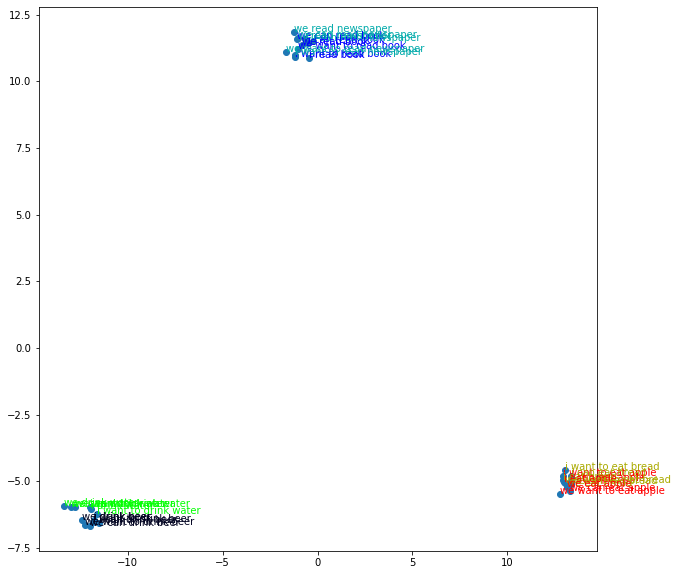

In [112]:
#OUTPUT BY CLS
pooler_outputs = [ get_CLS_output(s,tokenizer,bert_model).detach().numpy() for s in sentences]
dump_on_surface(pooler_outputs,sentences,fitting="pca",dump_3d=False,color_by="object")

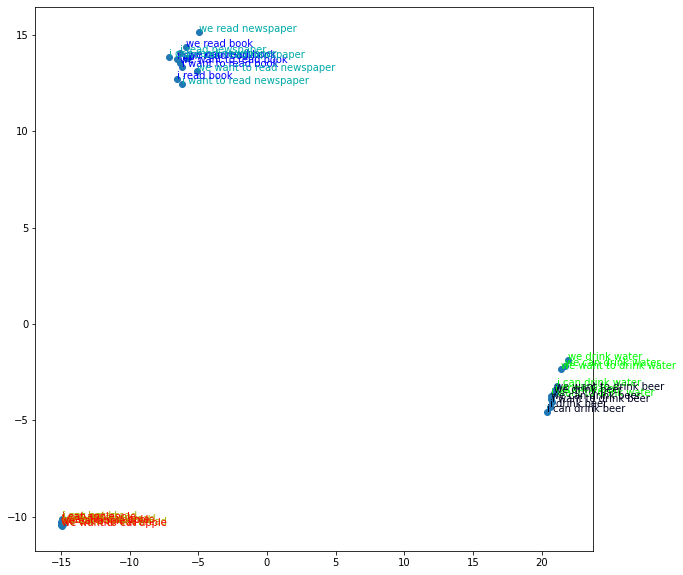

In [113]:
#GET POOLER OUTPUT
outputs = [ get_pooler_outputfrom(s,tokenizer,bert_model).detach().numpy() for s in sentences]

#dump_on_surface(pooler_outputs,sentences,fitting="tsne",color_by="object")
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,color_by="object")
     

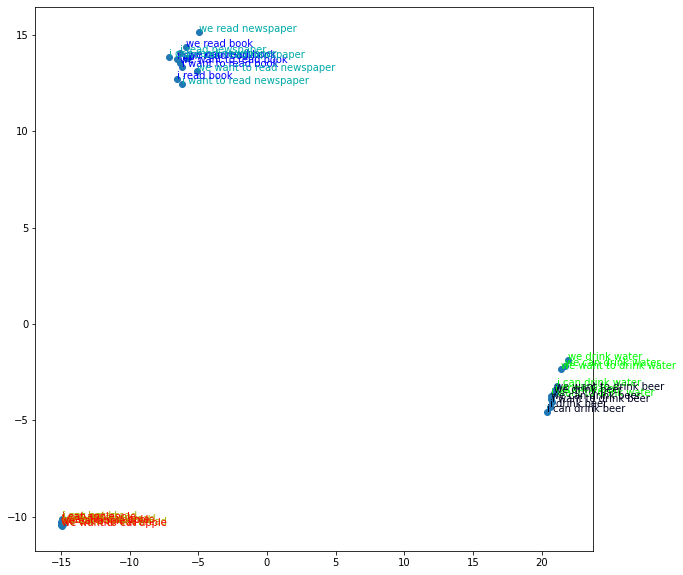

In [114]:
outputs = [ get_pooler_outputfrom(s,tokenizer,bert_model).detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,color_by="object")

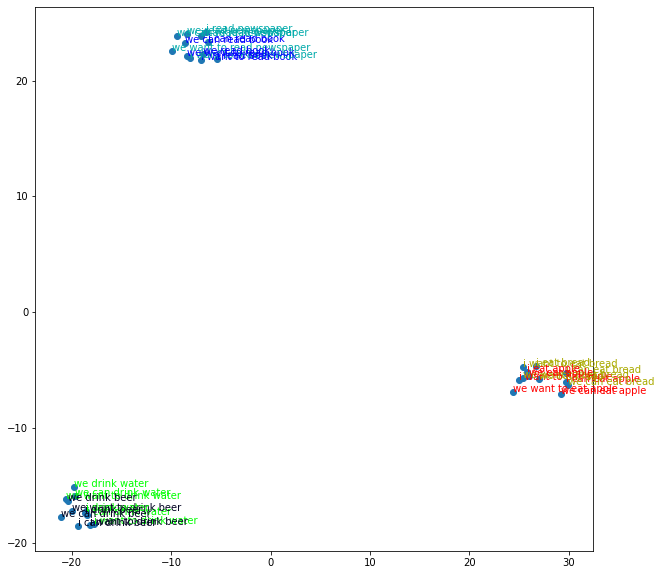

In [115]:
#GET OUTPUT BY HIDDEN LAYYER EMBEDDINGS


outputs = [ get_sentence_embedding(tokenizer,bert_model,s,type="meansum").detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,color_by="object")

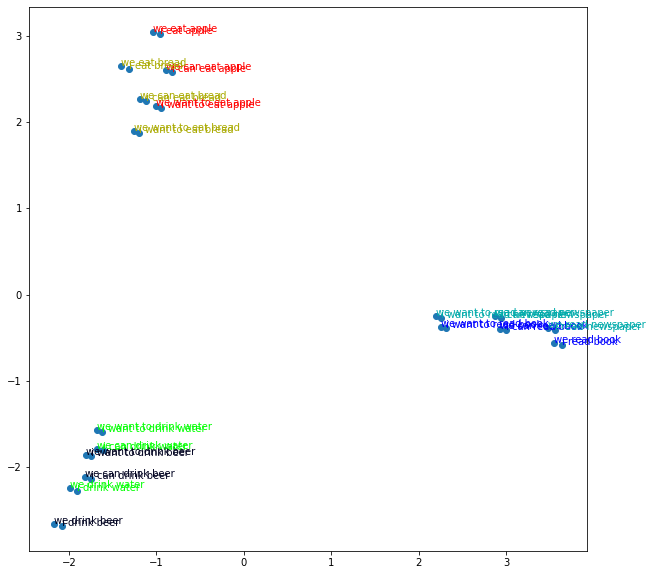

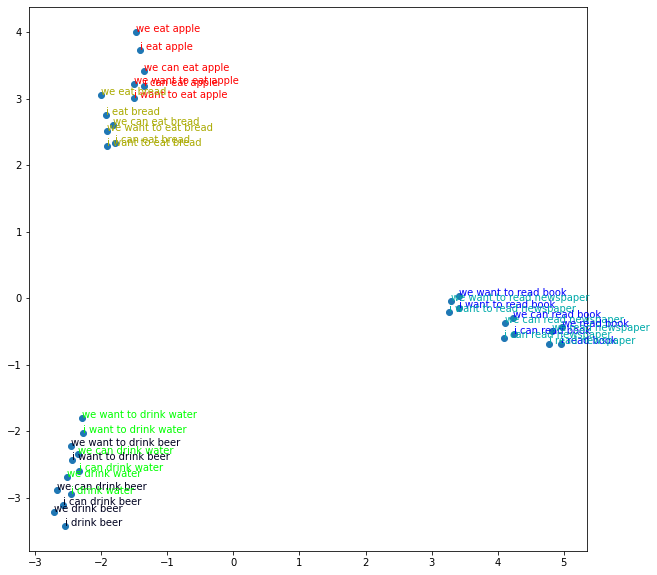

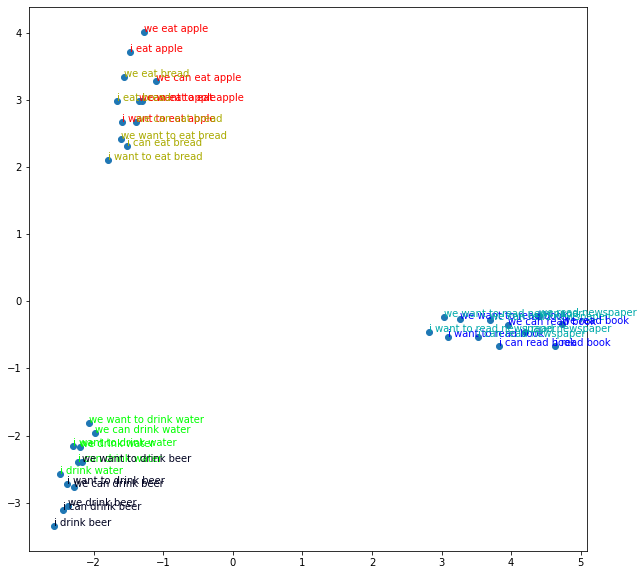

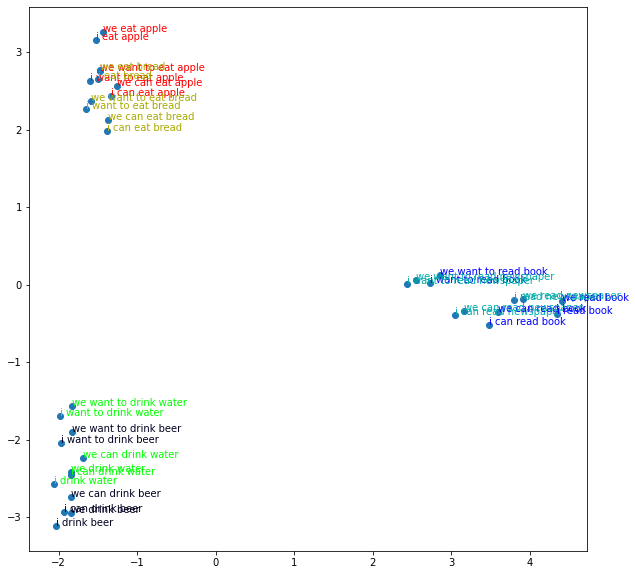

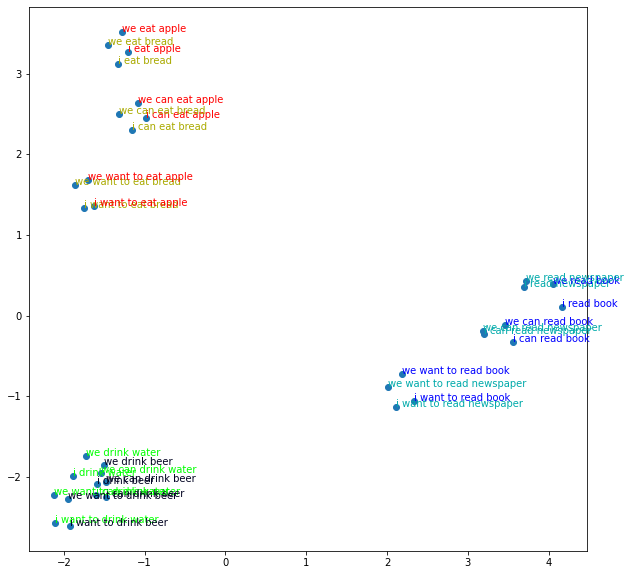

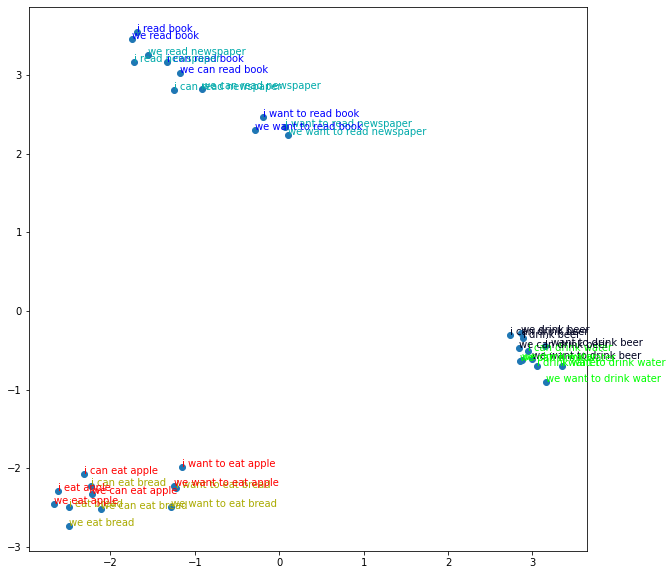

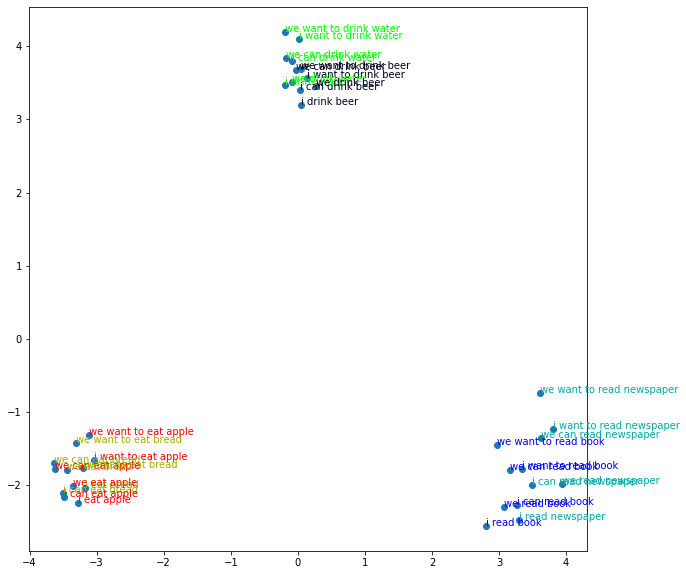

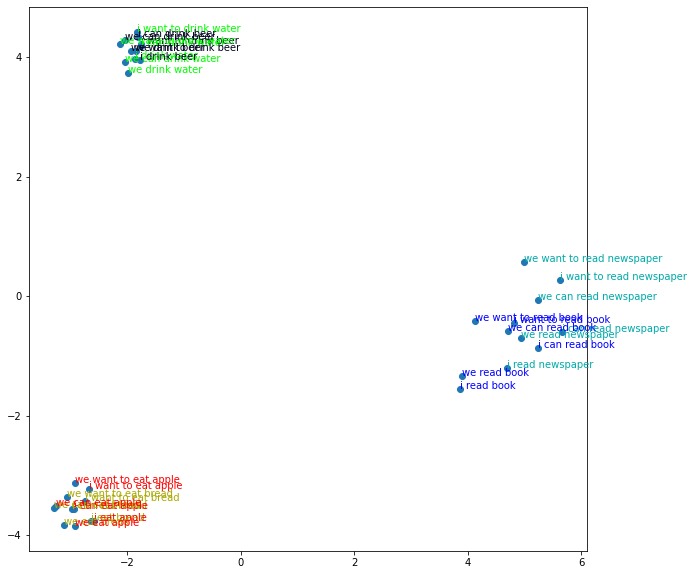

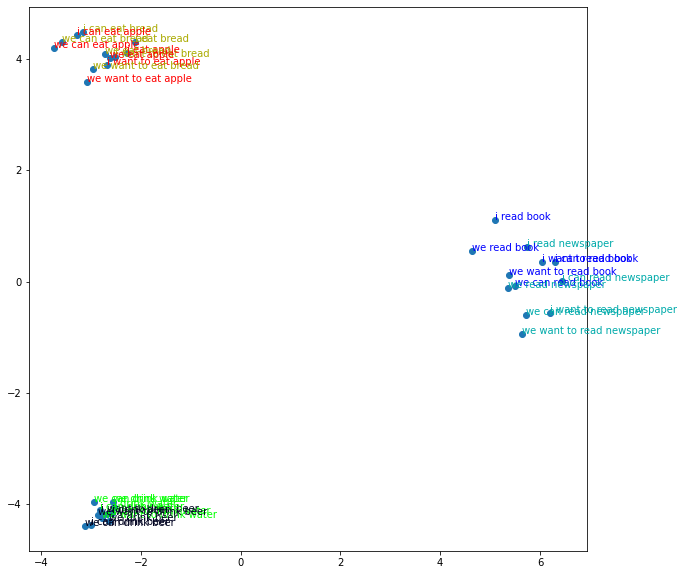

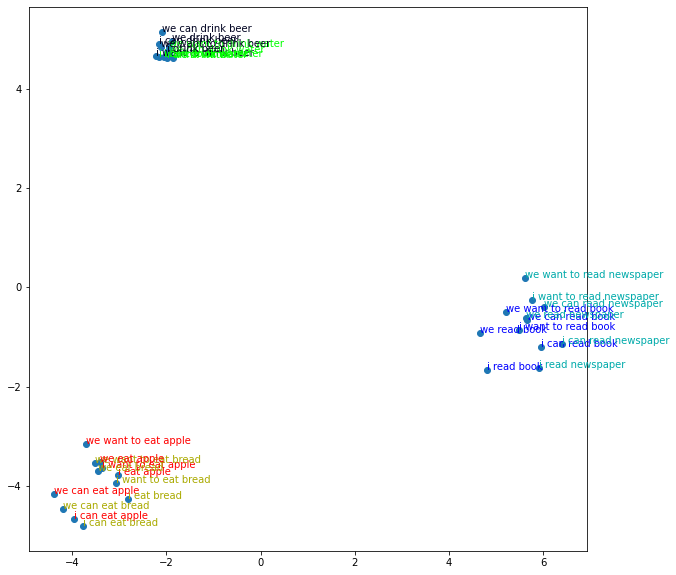

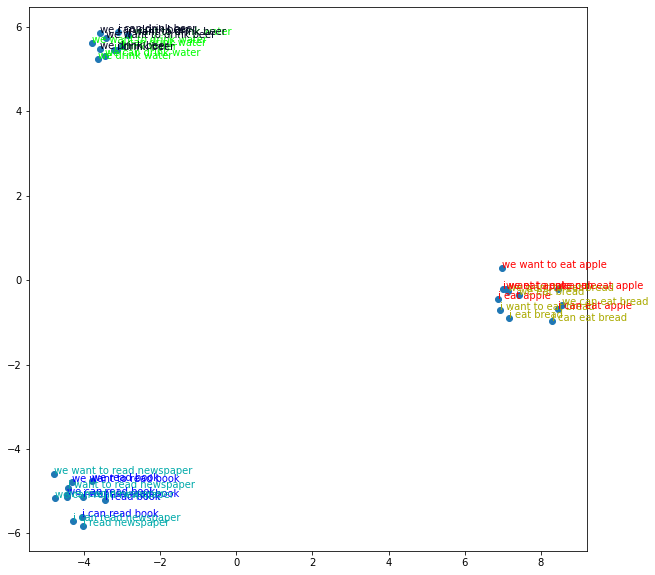

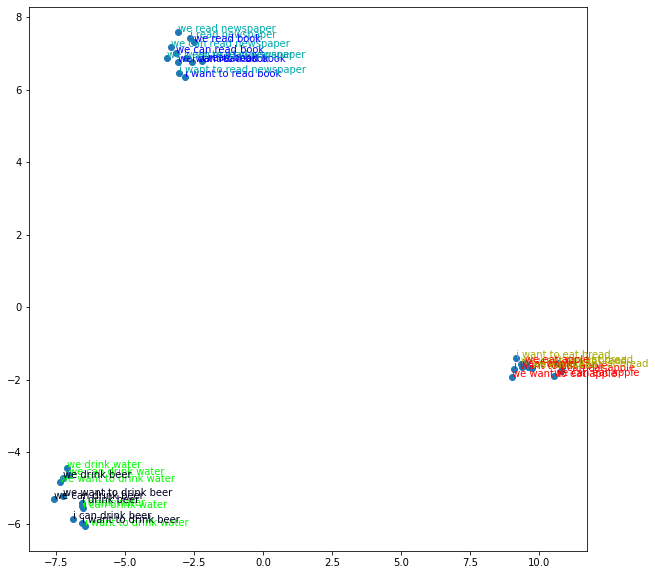

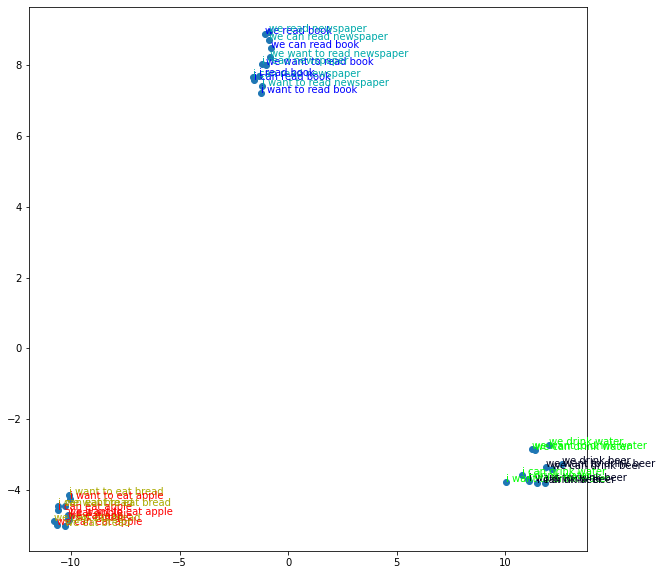

In [116]:
for i in range(13):
    outputs = [ get_sentence_embedding(tokenizer,bert_model,s,layer_start=i,layer_end=i+1,type="meansum").detach().numpy() for s in sentences]
    
    dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,color_by="object")